# Signal processing of stream gauge temperature data for identification of flow activation and cessation

In [1]:
import os
import numpy as np
np.random.seed(314)

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

from scipy.signal import wiener

%matplotlib inline

In [2]:
fontsize = 10 # points
a4_width = 7 # inches 
half_page_width = 3.5 # inches

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : fontsize}

mpl.rc('font', **font)
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams["legend.fontsize"] = fontsize
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

## Synthetic example for temperature time series

A temperature time series for a temperature logger can be thought of as having the following characteristics:
1. A climate variation signal
1. A seasonal variation with a yearly periodicity
2. A daily variation 
3. A noise component
4. A dampening of amplitude during flow or significant rainfall due to dampening or the ambient temperature signal

The seasonal and daily variation can be generated with sine waves of the form:

$y = A sin(B(x + C)) + D$

where:
- amplitude is $A$
- period is $2\pi/B$
- phase shift is $C$ (positive is to the left)
- vertical shift is $D$

The noise component can be represented by sampling from a normal distribution.

The effect of dampening of the signal through the presence of flow in the stream can be achieved by applying a Wiener filter to the sum of the seasonal, daily and noise components. Alternatively, the streamflow signal can be applied multiplicatively, which in essence is similar anyway.


#### 2 synthetic examples
1. Low noise
2. High noise

Each has 5 flow events:
1. Sub-daily (1 event)
2. Daily; and (1 event)
3. Multi-day (3 events)

For the multi-day events there are three levels of dampening as a result of flow simulating larger depth of water over the sensor and more diffusion of air temperature signal:
1. Developed flow
2. Normal flow
3. Barely flowing / ponding 

In [4]:
# y=Asin(B(x+C))+Dy=Asin(B(x+C))+D

n_times = 365 * 24 * 60 / 30
t_synthetic = np.linspace(0, 365, n_times)

# Climate variation signal modelled as linear increase over time
climate_variation = t_synthetic * 0.01

# Seasonal variation with a yearly periodicity
A = 15
B = 2 * np.pi / 365 
C = np.pi / 2.
D = 25.
seasonal = 15 * np.sin(t_synthetic / 365. * (2 * np.pi) + np.pi / 2.) + 25.

# Diurnal variation
daily = 5 * np.sin(t_synthetic / 1. * (2 * np.pi) - np.pi / 2.)

# A noise component that modelling stochastic natural sub-daily variability due to weather
final_temps = []
noise = []
for ind, noise_factor in enumerate([1, 4, 8]): 
    noise += [(np.random.random(n_times) - 0.5) * noise_factor]

    # A dampening of amplitude during flow or significant rainfall due to dampening or the ambient temperature signal
    ## Sub-daily
    flow_start = 30
    flow_finish = 30.4
    ## Daily
    flow_start2 = 90 
    flow_finish2 = 91
    ## Multi-day_1 
    flow_start3 = 140
    flow_finish3 = 144
    ## Multi-day_2
    flow_start4 = 200
    flow_finish4 = 204
    ## Multi-day_3
    flow_start5 = 260
    flow_finish5 = 264
    
    flow_starts = [flow_start, flow_start2, flow_start3, flow_start4, flow_start5]
    flow_finishes = [flow_finish, flow_finish2, flow_finish3, flow_finish4, flow_finish5]
    flow_event = np.piecewise(t_synthetic, 
                              [t_synthetic < flow_start, 
                               (t_synthetic > flow_start) == (t_synthetic < flow_finish) , 
                               (t_synthetic >= flow_finish) == (t_synthetic <= flow_start2),
                               (t_synthetic > flow_start2) == (t_synthetic < flow_finish2), 
                               (t_synthetic >= flow_finish2) == (t_synthetic <= flow_start3),
                               (t_synthetic > flow_start3) == (t_synthetic < flow_finish3), 
                               (t_synthetic >= flow_finish3) == (t_synthetic <= flow_start4),
                               (t_synthetic > flow_start4) == (t_synthetic < flow_finish4), 
                               (t_synthetic >= flow_finish4) == (t_synthetic <= flow_start5),
                               (t_synthetic > flow_start5) == (t_synthetic < flow_finish5), 
                               (t_synthetic >= flow_finish5)], 
                              [0, 1, 0, 1, 0, 3, 0, 2, 0, 0.6, 0])

    final_temp = climate_variation + seasonal + daily + noise[ind]
    # ---> Apply filter
    # Deep flow
    y_temp_wiener = wiener(final_temp, mysize=[220])
    final_temp[(flow_event > 0.5) & (t_synthetic < flow_start4)] = y_temp_wiener[(flow_event > 0.5) & (t_synthetic < flow_start4)]
    # Normal flow
    y_temp_wiener2 = wiener(final_temp, mysize=[120])
    final_temp[(flow_event > 0.5) & (t_synthetic >= flow_start4) & (t_synthetic < flow_start5)] =\
         y_temp_wiener2[(flow_event > 0.5) & (t_synthetic >= flow_start4) & (t_synthetic < flow_start5)]
    # Barely flowing
    y_temp_wiener3 = wiener(final_temp, mysize=[20])
    final_temp[(flow_event > 0.5) & (t_synthetic >= flow_start5)] =\
        y_temp_wiener3[(flow_event > 0.5) & (t_synthetic >= flow_start5)]
    # ---> Final Temperature
    final_temps += [final_temp]

noise_label = ['Low', 'Medium', 'High']
for i in range(3):
    synth_temp_df = pd.DataFrame(index=t_synthetic, data={"Temperature":final_temps[i]})
    synth_temp_df.to_csv("synthetic_temperature_{}.csv".format(noise_label[i]))    

### The influence of the Wiener filter

The influence of the wiener filter window size is shown below. As can be seen the larger the filter window, the larger the sqeezing/compression of the signal. Also, there are clear edge effects apparent; however, as all events considered are at suitable distance from the edges, this is not problematic.

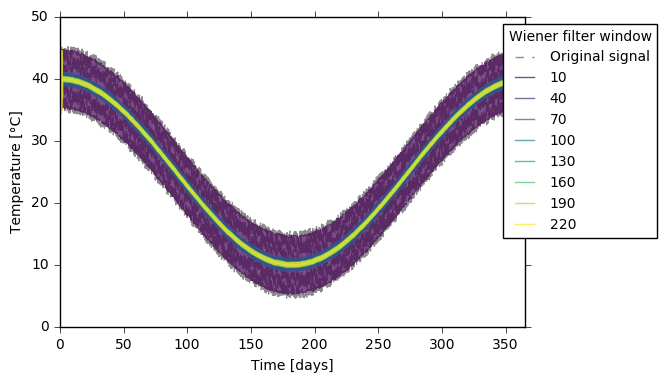

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
cmap3 = mpl.cm.get_cmap('viridis', len(range(10, 240, 30)))
ax.plot(t_synthetic, seasonal + daily + noise[0], c='grey', linestyle='--', alpha=0.9, label='Original signal')
ax.set_xlabel('Time [days]')
ax.set_ylabel(u"Temperature [\u00B0C]")
ax.set_xlim(0, 365)
for ind, siz in enumerate(range(10, 240, 30)):
    ax.plot(t_synthetic, wiener(seasonal + daily + noise[0], mysize=[siz]), c=cmap3(ind), alpha=0.7, label=siz)
plt.legend(bbox_to_anchor=(1.3, 1), title='Wiener filter window')

### Plotting of synthetic flow series

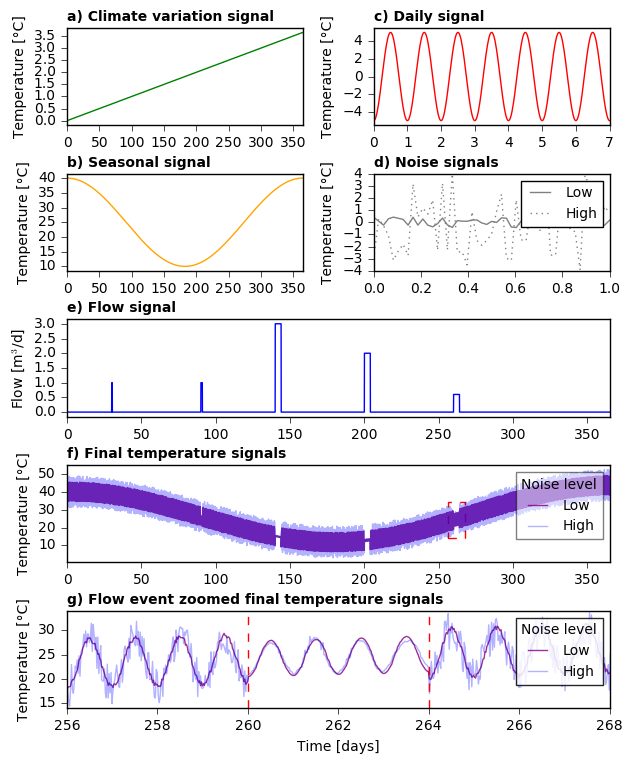

In [7]:
def set_labels(ax, x=True, y=True):
    if y: ax.set_ylabel(u"Temperature [\u00B0C]")
    if x: ax.set_xlabel("Time [days]")

def adjust_ylim(ax, ymin, ymax, factor=0.05):
    diff = ymax - ymin
    ax.set_ylim(ymin - diff * factor, ymax + diff * factor)
        
signal_color_dict = {'climate': 'green',
                     'seasonal': 'orange',        
                     'daily': 'red',
                     'noise': 'grey',
                     'flow': 'blue',
                     'final': 'blue'
                    }        

fig = plt.figure(figsize=(a4_width, 8))

gs = gridspec.GridSpec(5, 2)

def plot_panel(gs_ref, x_series, y_series, name, title, xmin, xmax, isxlabel=True, isylabel=True):
    ax = fig.add_subplot(gs_ref)
    ax.plot(t_synthetic, y_series, color=signal_color_dict[name])
    ax.set_title(title, loc="left")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(xmin, xmax)
    ymin = y_series.min()
    ymax = y_series.max()
    adjust_ylim(ax, ymin, ymax)
    set_labels(ax, x=isxlabel, y=isylabel)
    return ax

plot_panel(gs[0, 0], t_synthetic, climate_variation, 'climate', 
           "a) Climate variation signal", 0, 365, isxlabel=False)

plot_panel(gs[1, 0], t_synthetic, seasonal, 'seasonal', 
           "b) Seasonal signal", 0, 365, isxlabel=False)

plot_panel(gs[0, 1], t_synthetic, daily, 'daily', 
           "c) Daily signal", 0, 7, isxlabel=False)

ax3 = fig.add_subplot(gs[1, 1])
noise_linestyle = ['-', '--', ':']
noise_label = ['Low', 'Medium', 'High']
noise_inds = [0, 2]
for i in noise_inds:
    ax3.plot(t_synthetic, noise[i], linestyle=noise_linestyle[i], color=signal_color_dict['noise'], label=noise_label[i])
plt.legend(fontsize='medium')
ax3.set_title("d) Noise signals", loc="left")
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_xlim(0, 1)
#ymin = noise.min()
#ymax = noise.max()
#adjust_ylim(ax3, ymin, ymax)
set_labels(ax3, x=False)

ax4 = plot_panel(gs[2, :], t_synthetic, flow_event, 'flow', 
           "e) Flow signal", 0, 365, isxlabel=False)
ax4.set_ylabel("Flow [m$^3$/d]")

ax5 = fig.add_subplot(gs[3, :])
ax5.set_title("f) Final temperature signals", loc="left")
ax5.yaxis.set_ticks_position('left')
ax5.xaxis.set_ticks_position('bottom')
alphas = [0.8, 0.5, 0.3]
final_colors = ['purple', 'green', 'blue']
for i in noise_inds:
    ax5.plot(t_synthetic, final_temps[i], color=final_colors[i], alpha=alphas[i], label=noise_label[i])
ax5.set_xlim(0, 365)
plt.legend(title="Noise level", fontsize=fontsize, framealpha=0.5)
bottom_left = (flow_start5 - 4, 14)  
width = flow_finish5 + 4 - (flow_start5 - 4) 
height = 20
ax5.add_patch(mpl.patches.Rectangle(bottom_left, width, height, linestyle='--', zorder=0, color='red', fill=False))
ymin = final_temp.min()
ymax = final_temp.max()
adjust_ylim(ax5, ymin, ymax)
set_labels(ax5, x=False)

ax6 = fig.add_subplot(gs[4, :])
ax6.set_title("g) Flow event zoomed final temperature signals", loc="left")
ax6.yaxis.set_ticks_position('left')
ax6.xaxis.set_ticks_position('bottom')
for i in noise_inds:
    ax6.plot(t_synthetic, final_temps[i], color=final_colors[i], alpha=alphas[i], label=noise_label[i])
ax6.set_xlim(flow_start5 - 4, flow_finish5 + 4)
ax6.axvline(flow_start5, color='red', linestyle='--')
ax6.axvline(flow_finish5, color='red', linestyle='--')
plt.legend(title="Noise level", fontsize=fontsize, framealpha=0.85)
ax6.set_ylim(14, 34)
set_labels(ax6)

plt.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.1, top=0.95)

plt.savefig("Synthetic_stream_temperature_example_gs.png", dpi=300)
plt.savefig("Synthetic_stream_temperature_example_gs.pdf")